
### Raj Patil  
### CS18BTECH11039


#### **Welcome to Assignment 2**
This assignment consists of three parts. Part-1 is based on the content you learned in Week-3 of course and Part-2 is based on the content you learned in Week-4 of the course. Part-3 is **un-graded** and mainly designed to help you flex the Deep Learning muscles grown in Part-2. 

Unlike the first two parts, you'll have to implement everything from scratch in Part-3. If you find answers to questions in Part-3, feel free to head out to the forums and discuss them with your classmates!

#### **Instructions**
1. Use Python 3.x to run this notebook
2. Write your code only in between the lines 'YOUR CODE STARTS HERE' and 'YOUR CODE ENDS HERE'.
you should not change anything else in the code cells, if you do, the answers you are supposed to get at the end of this assignment might be wrong.
3. Read documentation of each function carefully.
4. All the Best!

# Part-1

In [7]:
# Imports
import numpy as np
import cv2
import matplotlib.pyplot as plt
from PIL import Image
from tqdm import tqdm
# %matplotlib inline uncomment this line if you're running this notebook on your local PC

In [ ]:
# DO NOT CHANGE THIS CODE
np.random.seed(10)

### Question 1 : Line detection from a given image.


Find the starting and ending point co-ordinates of detected lines of a given image (line.png) using hough transform.

Following criterion need to be satisfied to qualify as a line:

(a) Minimum line length = 60;
(b) Maximum allowed gap between line segments = 250;
(c) Accumulator threshold parameter = 15  (only those lines are returned that get enough votes);
(d) Distance resolution of the accumulator in pixels = 1;
(e) Angle resolution of the accumulator in radians = pi/180



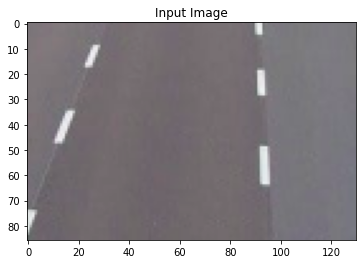

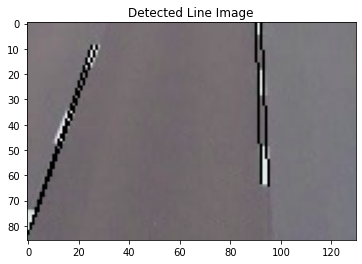

In [ ]:
#Read image 
img = cv2.imread('line.png', cv2.IMREAD_COLOR)

# Visualize the input image
plt.imshow(img)
plt.title('Input Image')
plt.show()

#### YOUR CODE STARTS HERE #####
#convert the image to gray-scale
gray = cv2.cvtColor(img,cv2.COLOR_BGR2GRAY)
#### YOUR CODE ENDS HERE #####

#Find the edges in the image using canny detector

edges = cv2.Canny(gray, 50, 200)

#### YOUR CODE STARTS HERE #####
min_line_len = 60
max_line_gap = 250
d_res = 1
a_res = np.pi/180
acc_thresh = 15

lines = cv2.HoughLinesP(edges,
                        d_res,
                        a_res,
                        acc_thresh,
                        minLineLength=min_line_len,
                        maxLineGap=max_line_gap)
for l in lines:
    x1,y1,x2,y2 = l[0]
    cv2.line(img,(x1,y1),(x2,y2),(0,0,0),1)


#### YOUR CODE ENDS HERE #####
plt.imshow(img)
plt.title('Detected Line Image')
plt.show()

##Question 2: Point matching using RANSAC

Given two sets of points related by affine transformation(with an outlier rate), use the RANSAC method to estimate the Affine transformation parameters between them and the number of inliers(Matching points).

What is the estimated number of inliers for an outlier rate of 0.9?


The estimated number is slightly more than 100 for the best model as some random points may turn out to be inliers. 

In [27]:
import numpy as np
np.random.seed(0)


# Affine Transformation
# |x'|  = |a, b| * |x|  +  |tx|
# |y'|    |c, d|   |y|     |ty|
# points_t =    A   * points_s  + t

# -------------------------------------------------------------

class Transform():

    def create_case(self, out_rate):
        ''' CREATE_CASE

            Method to generate a test case for affine transformation

            Input arguments:
            - out_rate : the percentage of outliers in test case

            Outputs:
            - points_s : Source points that will be transformed
            - points_t : warped points
            - A, t : parameters of affine transformation, A is a 2x2
            matrix, t is a 2x1 vector, both of them are created randomly

        '''


        # Generate an affine transformation
        # A is a 2x2 matrix, with values in range -2 to 2
        A = 4 * np.random.rand(2, 2) - 2

        # t is a 2x1 vector, with values in range -10 to 10
        t = 20 * np.random.rand(2, 1) - 10

        # Set the num_points = 1000 for the test case
        num_points = 1000

        #### YOUR CODE STARTS HERE ####
        # Compute the no. of outliers and the no. of inliers respectively
        outliers = int(num_points*out_rate)
        inliers = num_points - outliers
        #### YOUR CODE ENDS HERE ####

        # Gernerate source points, with scope from (0,0) to (100, 100)
        points_s = 100 * np.random.rand(2, num_points)

        # Initialization of the warped points matrix
        points_t = np.zeros((2, num_points))

        #### YOUR CODE STARTS HERE ####
        # Compute inliers in warped points matrix by applying A and t
        points_t[:, :inliers] = A @ points_t[:,:inliers] + t
        #### YOUR CODE ENDS HERE ####

        # Outliers in warped points matrix
        points_t[:, inliers:] = 100 * np.random.rand(2, outliers)

        # Reset the order of warped points matrix
        # outliers and inliers will scatter randomly in test case
        rand_inx = np.random.permutation(num_points)
        points_s = points_s[:, rand_inx]
        points_t = points_t[:, rand_inx]

        return A, t, points_s, points_t

    def affine_transformation(self, points_s, points_t):  
        ''' AFFINE_TRANSFORMATION

            Perform affine transformation

            Input arguments:
            - points_t : points in target image
            - points_s : points in source image

            Outputs:

            - A, t : the affine transformation, A is a 2x2 matrix
            that indicates the rotation and scaling transformation,
            t is a 2x1 vector determines the translation

            Method:

            To estimate an affine transformation between two images,
            at least 3 corresponding points are needed.
            In this case, 6-parameter affine transformation are taken into
            consideration, which is shown as follows:

            | x' | = | a b | * | x | + | tx |
            | y' |   | c d |   | y |   | ty |

            For 3 corresponding points, 6 equations can be formed as below:

            | x1 y1 0  0  1 0 |       | a  |       | x1' |
            | 0  0  x1 y1 0 1 |       | b  |       | y1' |
            | x2 y2 0  0  1 0 |   *   | c  |   =   | x2' |
            | 0  0  x2 y2 0 1 |       | d  |       | y2' |
            | x3 y3 0  0  1 0 |       | tx |       | x3' |
            | 0  0  x3 y3 0 1 |       | ty |       | y3' |

            |------> M <------|   |-> theta <-|   |-> b <-|

            Solve the equation by calculating:  theta = M \ b
            Thus, affine transformation can be obtained as:

            A = | a b |     t = | tx |
                | c d |         | ty |

        '''

        #### YOUR CODE STARTS HERE ####
        points_s,points_t = points_s.squeeze(),points_t.squeeze()

        x1,y1 = points_s[0][0],points_s[1][0]
        x2,y2 = points_s[0][1],points_s[1][1]
        x3,y3 = points_s[0][2],points_s[1][2]

        x_1,y_1 = points_t[0][0],points_t[1][0]
        x_2,y_2 = points_t[0][1],points_t[1][1]
        x_3,y_3 = points_t[0][2],points_t[1][2]

        M = np.array([[x1,y1,0,0,1,0],
                        [0,0,x1,y1,0,1],
                        [x2,y2,0,0,1,0],
                        [0,0,x2,y2,0,1],
                        [x3,y3,0,0,1,0],
                        [0,0,x3,y3,0,1]])
                        
        b = np.array([x_1,y_1,x_2,y_2,x_3,y_3])

        try:
            theta = np.linalg.lstsq(M,b)[0]
        except :
            # in case a singular matrix is encountered
            return None,None
        A = np.array([[theta[0],theta[1]],
                        [theta[2],theta[2]]])
        t = np.array([[theta[4],theta[5]]]).T

        return A,t
        #### YOUR CODE ENDS HERE ####
# -------------------------------------------------------------

# Create instance
tf = Transform()

# Generate a test case as validation with
# a rate of outliers
out_rate = 0.90
A_true, t_true, points_s, points_t = tf.create_case(out_rate)

# At least 3 corresponding points to
# estimate affine transformation
L = 3
# Randomly select 3 pairs of points to do estimation
idx = np.random.randint(0, points_s.shape[1], (L, 1))

A_test, t_test = tf.affine_transformation(points_s[:, idx], points_t[:, idx])

# -------------------------------------------------------------
# Test Class RansacClass
# The number of iterations in RANSAC
ITER_NUM = 2000


class RansacClass():

    def __init__(self, L=3, thr=1): 
        ''' __INIT__

            Initialize the instance.

            Input arguments:

            - L : the number of corresponding points,
            default is 3
            - thr : threshold that determines which points are inliers
            by comparing residual with it

        '''

        self.L = L
        self.thr = thr

    def calculate_distance(self, A, t, points_s, points_t):     
        ''' CALCULATE_DISTANCE

            Compute residual length between estimation and 
            real target points.
 

            Input arguments:

            - A, t : the estimated affine transformation
                     (using least square)
            - points_s : key points taken from source image
            - points_t : key points taken from target image

            Output:

            - residual : Euclidean distance between target 
            points and estimated points. Euclidean distance is
            nothing but the residual length

        '''

        ###YOUR CODE START HERE
        if A is None or t is None:
            return None
        points_e  = A @ points_s + t

        res = np.sqrt(((points_e - points_t)**2).sum(axis=0))

        return res
        ###YOUR CODE ENDS HERE

    def apply_ransac(self, points_s, points_t):
        ''' APPLY_RANSAC

            Use this method to get the estimated affine 
            transformation, also inliers.

            Input arguments:

            - points_s : key points from source image
            - points_t : key points from target image

            Output:

            - A, t : estimated affine transformation
            - inliers : indices of inliers 

        '''
        #### YOUR CODE START HERE

        mostInliers = []

        gA,gt  = None,None

        for i in tqdm(range(ITER_NUM)):
            idx = np.random.randint(0, points_s.shape[1], (self.L, 1))
            gA,gt = tf.affine_transformation(points_s[:,idx],points_t[:,idx]) # guessing A and t
            if gA is None or gt is None:
                continue

            res = self.calculate_distance(gA,gt,points_s,points_t)

            if res is None:
                continue

            inliers_idx_bool = (res<=self.thr)

            if sum(inliers_idx_bool) > len(mostInliers):
                mostInliers = np.array(range(1000))[inliers_idx_bool]
                bestModel = gA,gt
        
        bA,bt = bestModel
        return bA,bt,mostInliers
        #### YOUR CODE ENDS HERE
# -------------------------------------------------------------

# Create instance
rs = RansacClass(L=3, thr=1)

residual = rs.calculate_distance(A_test, t_test, points_s, points_t)
A_rsc, t_rsc, inliers = rs.apply_ransac(points_s, points_t)

# print the number of inliners or point matches
print()
print(inliers.shape)


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:134: FutureWarning: `rcond` parameter will change to the default of machine precision times ``max(M, N)`` where M and N are the input matrix dimensions.
To use the future default and silence this warning we advise to pass `rcond=None`, to keep using the old, explicitly pass `rcond=-1`.
100%|██████████| 2000/2000 [00:05<00:00, 366.51it/s]


(100,)


### Question 3: Detect corners in a given image using Harris Corner Detection Algorithm

Find the number of detected corner points in a given image (line.png) using Harris Corner Detection Algorithm. Note that, Following criterion MUST be satisfied while applying Harris Corner detection Algorithm:

(a)  The size of neighbourhood considered for corner detection = 2.
(b)  Aperture parameter of Sobel derivative used = 3.
(c)  Harris detector free parameter in the equation = 0.04.

How many corners are detected?



no. of corners detected:  222


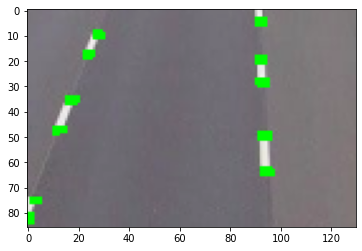

In [102]:
import matplotlib.pyplot as plt
import numpy as np
import cv2

%matplotlib inline

# Read in the image
image = cv2.imread('line.png')

# Make a copy of the image
image_copy = np.copy(image)

# Change color to RGB (from BGR)
image_copy = cv2.cvtColor(image_copy, cv2.COLOR_BGR2RGB)

###YOUR CODE STARTS HERE

## STEP 1:  Convert to grayscale 
gray = cv2.cvtColor(image,cv2.COLOR_BGR2GRAY)

## STEP 2: Detect corners 

corners = cv2.cornerHarris(gray,2,3,0.04)

## STEP 3: Dilate corner image to enhance corner points
corners = cv2.dilate(corners,None)

## STEP 4:set threshold value as 0.1 * (maximum value of dilated corner image obtained from STEP3)
threshold = 0.1 * corners.max()

## STEP 5: Count numer of detected corner points and draw them on the image
image_copy[corners>threshold] = [0,255,0]
detected_corners = (corners>threshold).sum()
print('no. of corners detected: ', detected_corners)
plt.imshow(image_copy)

### YOUR CODE ENDS HERE

# Part-2

In this section, we will train a neural network to learn to identify numerals from [MNIST](http://yann.lecun.com/exdb/mnist/) dataset. Fill out the missing pieces in each of the following cells. 

In [2]:
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import datasets, transforms
import torch.nn.functional as F
import timeit
import unittest
from tqdm import tqdm

## Please DONOT remove these lines. 
torch.manual_seed(0)
torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False
np.random.seed(0)

### Data Loading and Pre-processing

In [3]:
# check availability of GPU and set the device accordingly
#### YOUR CODE STARTS HERE ####
device = torch.device("cuda:0") if torch.cuda.is_available() else torch.device("cpu")

# define a transforms for preparing the dataset
transform = transforms.Compose([
                                transforms.ToTensor(),
                                transforms.Normalize((0.1307,),(0.3081,))
])
         # convert the image to a pytorch tensor
        # normalise the images with mean (0.1307) and std (0.3081) of the dataset
#### YOUR CODE ENDS HERE ####

In [4]:
# Load the MNIST training, test datasets using `torchvision.datasets.MNIST` using the transform defined above
#### YOUR CODE STARTS HERE ####
train_dataset = datasets.MNIST( root='./data', train=True,
                                            download=True, transform=transform)
test_dataset = datasets.MNIST( root='./data',train=False,
                                            download=True, transform=transform)
#### YOUR CODE ENDS HERE ####

Extracting ./data/MNIST/raw/train-images-idx3-ubyte.gz to ./data/MNIST/raw


Extracting ./data/MNIST/raw/train-labels-idx1-ubyte.gz to ./data/MNIST/raw


Extracting ./data/MNIST/raw/t10k-images-idx3-ubyte.gz to ./data/MNIST/raw


Extracting ./data/MNIST/raw/t10k-labels-idx1-ubyte.gz to ./data/MNIST/raw
Processing...
Done!


/usr/local/lib/python3.7/dist-packages/torchvision/datasets/mnist.py:480: UserWarning: The given NumPy array is not writeable, and PyTorch does not support non-writeable tensors. This means you can write to the underlying (supposedly non-writeable) NumPy array using the tensor. You may want to copy the array to protect its data or make it writeable before converting it to a tensor. This type of warning will be suppressed for the rest of this program. (Triggered internally at  /pytorch/torch/csrc/utils/tensor_numpy.cpp:141.)
  return torch.from_numpy(parsed.astype(m[2], copy=False)).view(*s)


In [5]:
# create dataloaders for training and test datasets
# use a batch size of 32 and set shuffle=True for the training set
#### YOUR CODE STARTS HERE ####
train_dataloader = torch.utils.data.DataLoader(train_dataset,batch_size=32,
                                               shuffle=True,num_workers=2)
test_dataloader = torch.utils.data.DataLoader(test_dataset,batch_size=32,
                                              shuffle=False,num_workers=2) 
#### YOUR CODE ENDS HERE ####

### Network Definition

In [6]:
class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        #### YOUR CODE STARTS HERE ####
        # define a conv layer with output channels as 16, kernel size of 3 and stride of 1
        self.conv1 = nn.Conv2d(in_channels=1,out_channels=16,kernel_size=3,stride=1)
        # define a conv layer with output channels as 32, kernel size of 3 and stride of 1
        self.conv2 = nn.Conv2d(in_channels=16,out_channels=32,kernel_size=3,stride=1)
        # define a conv layer with output channels as 64, kernel size of 3 and stride of 1
        self.conv3 = nn.Conv2d(in_channels=32,out_channels=64,kernel_size=3,stride=1)
        # define a max pooling layer with kernel size 2
        self.pool = nn.MaxPool2d(kernel_size=2,stride=2)
        
        # define dropout layer with a probability of 0.25
        self.drop_qrt = nn.Dropout2d(p=0.25)
        # define dropout layer with a probability of 0.5
        self.drop_hlf = nn.Dropout2d(p=0.5)
        # define a linear(dense) layer with 128 output features
        self.fc1 = nn.Linear(in_features=64*11*11,out_features=128)
        # define a linear(dense) layer with output features corresponding to the number of classes in the dataset
        self.fc2 = nn.Linear(in_features=128,out_features=10)
        #### YOUR CODE ENDS HERE ####

    def forward(self, x):
        # Use the layers defined above in a sequential way (folow the same as the layer definitions above) and 
        # write the forward pass, after each of conv1, conv2, conv3 and fc1 use a relu activation. 
        # use the first dropout after maxpool and the other one before you final FC layer
        #### YOUR CODE STARTS HERE ####
        out = F.relu(self.conv1(x))
        out = F.relu(self.conv2(out))
        out = self.drop_qrt(self.pool(F.relu(self.conv3(out))))
        out = out.view(-1,64*11*11)
        out = F.relu(self.fc1(out))
        out = self.fc2(self.drop_hlf(out))
        #### YOUR CODE ENDS HERE ####
        output = F.log_softmax(out, dim=1)
        return output

### Sanity Check
Make sure all the tests below pass without any errors, before you proceed with the training part.

In [7]:
import unittest

class TestImplementations(unittest.TestCase):
    
    # Dataloading tests
    def test_dataset(self):
        self.dataset_classes = ['0 - zero',
                                '1 - one',
                                '2 - two',
                                '3 - three',
                                '4 - four',
                                '5 - five',
                                '6 - six',
                                '7 - seven',
                                '8 - eight',
                                '9 - nine']
        self.assertTrue(train_dataset.classes == self.dataset_classes)
        self.assertTrue(train_dataset.train == True)
    
    def test_dataloader(self):        
        self.assertTrue(train_dataloader.batch_size == 32)
        self.assertTrue(test_dataloader.batch_size == 32)      
         
    def test_total_parameters(self):
        model = Net().to(device)
        self.assertTrue(sum(p.numel() for p in model.parameters()) == 1015946)

suite = unittest.TestLoader().loadTestsFromModule(TestImplementations())
unittest.TextTestRunner().run(suite)

...
----------------------------------------------------------------------
Ran 3 tests in 10.034s

OK


<unittest.runner.TextTestResult run=3 errors=0 failures=0>

#### Logging setup

 - will be logging scalars and weight histograms in tensorboard
 - uploading the experiment results here:

In [4]:
from torch.utils.tensorboard import SummaryWriter
from pathlib import Path

from google.colab import drive
drive.mount('/content/drive')

#logs = Path('/content/drive/MyDrive/DL_A2_Logs')
#savedir = Path('/content/drive/MyDrive/DL_A2_Logs/logs')
savedir.mkdir(exist_ok=True)
assert(logs.exists() and savedir.exists())

Mounted at /content/drive


### Training and Inference

In [9]:
def train(model,
          device,
          train_loader,
          optimizer,
          epoch,
          criterion = nn.NLLLoss(),
          writer = None):
    model.train()
    for batch_idx, (data, target) in enumerate(train_loader):
      #### YOUR CODE STARTS HERE ####
        # send the image, target to the device
        data,target =  data.to(device),target.to(device)
        # flush out the gradients stored in optimizer
        optimizer.zero_grad()
        # pass the image to the model and assign the output to variable named output
        output = model(data)
        # calculate the loss (use nll_loss in pytorch)
        loss = criterion(output,target)
        # do a backward pass
        loss.backward()
        # update the weights
        optimizer.step()

        if writer is not None:
            ### LOGGING ###
            if batch_idx % 20 == 0:
                writer.add_scalar("Loss/Train",
                                loss.item(),
                                len(train_loader.dataset)*epoch + batch_idx*train_loader.batch_size)

      #### YOUR CODE ENDS HERE ####
        if batch_idx % 20 == 0:
            print('Train Epoch: {} [{}/{} ({:.0f}%)]\tLoss: {:.6f}'.format(
                epoch, batch_idx * len(data), len(train_loader.dataset),
                100. * batch_idx / len(train_loader), loss.item()))

In [10]:
def test(model, 
         device,
         test_loader,
         criterion = nn.NLLLoss(),
         writer = None,
         niters = None):
    model.eval()
    test_loss = 0
    correct = 0
    with torch.no_grad():
        for data, target in test_loader:
          ### YOUR CODE STARTS HERE ####
            # send the image, target to the device
            data,target = data.cuda(),target.cuda()
            # pass the image to the model and assign the output to variable named output
            output = model(data)
            test_loss += criterion(output,target)# sum up batch loss
          
            # get the index of the max log-probability
            _,pred = torch.max(output.data,1)

          #### YOUR CODE ENDS HERE ####
            correct += pred.eq(target.view_as(pred)).sum().item()

    test_loss /= len(test_loader.dataset)

    print('\nTest set: Average loss: {:.4f}, Accuracy: {}/{} ({:.0f}%)\n'.format(
        test_loss, correct, len(test_loader.dataset),
        100. * correct / len(test_loader.dataset)))

    ### Logging ###
    if writer is not None and niters is not None:
        writer.add_scalar("Accuracy/Test",
                        correct/len(test_loader.dataset),
                        niters)# aligning log with training iters
        writer.add_scalar("Loss/Test",test_loss,niters)

#### Logs of Q 4 to 9

In [ ]:
#%load_ext tensorboard
#%tensorboard --logdir "/content/drive/MyDrive/DL_A2_Logs"

#### uploading experiments to tensorboard dev

In [ ]:
#!tensorboard dev upload --logdir "/content/drive/MyDrive/DL_A2_Logs" --name "DL_A2_CS18BTECH11039" --description "Logs for questions 4 to 9 in Part II"

*The logs can now be accessed through* :   
<https://tensorboard.dev/experiment/foS0MgsZR12EAltZy3zliA/>  
experiment Name: `DL_A2_CS18BTECH11039`
- I have repeatedly referenced them in the following answers.
- will also be appending these and captured console outputs in the submission zip file

### Question 4

Use Adam as the optimiser and train the model for 25 epochs. Report the train, test loss and accuracies along with the total time taken for training. (Use plots if required)

final test accuracy : `99.39 %`  

---

final train loss  : `0.03941`  
final test loss   : `9.21e-4`  
total time taken  : `7m45s`

In [ ]:
%%capture cap --no-stderr
netq4 = Net()
netq4 = netq4.to(device)
optimizer = optim.Adam(netq4.parameters(),lr=0.001)
EPOCHS = 25

writer = SummaryWriter(logs/'Adam_Q4')
logfile = savedir/'Adam_Q4.txt'

# logging weights' histograms : pre_training
for name, weight in netq4.named_parameters():
    writer.add_histogram(f'pre_train/{name}', weight, global_step=1)

# Training
for epoch in range(EPOCHS):
    train(netq4,
          device,
          train_dataloader,
          optimizer,
          epoch,
          writer = writer)
    
    # logging loss and accuracy in each epoch and aligning with training data
    test(netq4,
        device,
        test_dataloader,
        writer = writer,
        niters = epoch*len(train_dataloader.dataset))# to align logs with trianing iterations

# logging weights' histograms : post_training
for name, weight in netq4.named_parameters():
    writer.add_histogram(f'post_train/{name}', weight, global_step=1)

torch.save(netq4,savedir/'Adam_Q4_model.pt')

In [ ]:
with open(logfile, 'w') as f:
     f.write(cap.stdout)

### Question 5

Modify the network defined in the previous step to replace ReLU activations with Sigmoid and report the final test accuracy. Is there a drop in accuracy, what do you think is the reason?



final test accuracy : `10.28 %`  

---

final train loss  : `2.284`  
final test loss   : `0.07209`  
total time taken  : `7m43s`

yes, there is a large drop in accuracy  
In fact one can hyothesize that the network did not learn anything because the accuracy is only slightly greater than that of a random model (10 percent) for 10 classes.

Hypothesis regarding the issue:
 - gradient saturation in sigmoid when the output of a neuron is extreme slows down the learning process
 - the original loss function may already be non-convex before, but more degrees of freedom, that control the non-convexity, are introduced by the sigmoid activations compared to the ReLU actications. This may complicate the loss contours vastly and makes it difficult to jump out of local minima due to the added problem of gradient saturation for certain neurons.

 to demonstrate the issue of gradient saturation, observing only the weights histogram for fc2 (final layer) for pedagogical purposes, see that the weights are not that spread apart compared to that of the net used in question 4 via this [link](
 https://tensorboard.dev/experiment/foS0MgsZR12EAltZy3zliA/#histograms&runSelectionState=eyJBZGFtX1E0Ijp0cnVlLCJCTjJEX1E5IjpmYWxzZSwiU0dEX25vTW9tX1E2IjpmYWxzZSwiU2lnbW9pZF9RNSI6dHJ1ZSwiaW5pdENvbnYyRF8xX1E3IjpmYWxzZSwiaW5pdFhhdmllcl9ub3JtX1E4IjpmYWxzZX0%3D&tagFilter=post_train%2Ffc2)  
(check the first tab under the `post_train/fc2` tag)

In [ ]:
class NetSigmoid(nn.Module):
    def __init__(self):
        super(NetSigmoid, self).__init__()
        #### YOUR CODE STARTS HERE ####
        # define a conv layer with output channels as 16, kernel size of 3 and stride of 1
        self.conv1 = nn.Conv2d(in_channels=1,out_channels=16,kernel_size=3,stride=1)
        # define a conv layer with output channels as 32, kernel size of 3 and stride of 1
        self.conv2 = nn.Conv2d(in_channels=16,out_channels=32,kernel_size=3,stride=1)
        # define a conv layer with output channels as 64, kernel size of 3 and stride of 1
        self.conv3 = nn.Conv2d(in_channels=32,out_channels=64,kernel_size=3,stride=1)
        # define a max pooling layer with kernel size 2
        self.pool = nn.MaxPool2d(kernel_size=2,stride=2)
        
        # define dropout layer with a probability of 0.25
        self.drop_qrt = nn.Dropout2d(p=0.25)
        # define dropout layer with a probability of 0.5
        self.drop_hlf = nn.Dropout2d(p=0.5)
        # define a linear(dense) layer with 128 output features
        self.fc1 = nn.Linear(in_features=64*11*11,out_features=128)
        # define a linear(dense) layer with output features corresponding to the number of classes in the dataset
        self.fc2 = nn.Linear(in_features=128,out_features=10)
        #### YOUR CODE ENDS HERE ####

    def forward(self, x):
        # Use the layers defined above in a sequential way (folow the same as the layer definitions above) and 
        # write the forward pass, after each of conv1, conv2, conv3 and fc1 use a relu activation. 
        # use the first dropout after maxpool and the other one before you final FC layer
        #### YOUR CODE STARTS HERE ####
        out = F.sigmoid(self.conv1(x))
        out = F.sigmoid(self.conv2(out))
        out = self.drop_qrt(self.pool(F.sigmoid(self.conv3(out))))
        out = out.view(-1,64*11*11)
        out = F.sigmoid(self.fc1(out))
        out = self.fc2(self.drop_hlf(out))
        #### YOUR CODE ENDS HERE ####
        output = F.log_softmax(out, dim=1)
        return output

In [ ]:
%%capture cap --no-stderr
netq5 = NetSigmoid()
netq5 = netq5.to(device)
optimizer = optim.Adam(netq5.parameters(),lr=0.001)
EPOCHS = 25

writer = SummaryWriter(logs/'Sigmoid_Q5')
logfile = savedir/'Sigmoid_Q5.txt'

# logging weights' histograms : pre_training
for name, weight in netq5.named_parameters():
    writer.add_histogram(f'pre_train/{name}', weight, global_step=1)

# Training
for epoch in range(EPOCHS):
    train(netq5,
          device,
          train_dataloader,
          optimizer,
          epoch,
          writer = writer)
    
    # logging loss and accuracy in each epoch and aligning with training data
    test(netq5,
        device,
        test_dataloader,
        writer = writer,
        niters = epoch*len(train_dataloader.dataset))# to align logs with trianing iterations

# logging weights' histograms : post_training
for name, weight in netq5.named_parameters():
    writer.add_histogram(f'post_train/{name}', weight, global_step=1)

torch.save(netq5,savedir/'Sigmoid_Q5_model.pt')

In [ ]:
with open(logfile, 'w') as f:
     f.write(cap.stdout)

### Question 6

Train the network defined in Question-1 with a different optimiser other than Adam, do you see any difference in performance? Substantiate your observations with relevant explanations.

Proceeding with SGD to get a baseline to compare what improvements ADAM offers.
also stripping off momentum: checking how large of a difference in convergence is observed at the end of training.

final test accuracy : `97.74 %`  

---

final train loss  : `0.03523`  
final test loss   : `2.42e-3`  
total time taken  : `7m5s`

Stripped of the optimizer of momentum this time and no LR schedulers are being used, so the lr is constant through out and hence we are not keeping track of our past in the updates.
Observations: 
 - slower convergence due to higher number of oscillations
    - 25 epochs were not enough for convergence
    - large oscillations can be verified by looking at the higher train loss frequency compared to that of Adam in the tensorboard link below
 - a lower final accuracy due the fact that one may never be able to land on the minimum accurated due to the oscillations
 - lesser time taken for the same number of iterations as lesser amount of compute is needed for each update.

 The comparison between Adam_Q4 and this net (SGD_noMom_Q6) can be accessed via this [link](https://tensorboard.dev/experiment/foS0MgsZR12EAltZy3zliA/#scalars&runSelectionState=eyJBZGFtX1E0Ijp0cnVlLCJCTjJEX1E5IjpmYWxzZSwiU0dEX25vTW9tX1E2Ijp0cnVlLCJTaWdtb2lkX1E1IjpmYWxzZSwiaW5pdENvbnYyRF8xX1E3IjpmYWxzZSwiaW5pdFhhdmllcl9ub3JtX1E4IjpmYWxzZX0%3D)


In [ ]:
%%capture cap --no-stderr
netq6 = Net()
netq6 = netq6.to(device)
optimizer = optim.SGD(netq6.parameters(),lr=0.001)
EPOCHS = 25

writer = SummaryWriter(logs/'SGD_noMom_Q6')
logfile = savedir/'SGD_noMom_Q6.txt'

# logging weights' histograms : pre_training
for name, weight in netq6.named_parameters():
    writer.add_histogram(f'pre_train/{name}', weight, global_step=1)

# Training
for epoch in range(EPOCHS):
    train(netq6,
          device,
          train_dataloader,
          optimizer,
          epoch,
          writer = writer)
    
    # logging loss and accuracy in each epoch and aligning with training data
    test(netq6,
        device,
        test_dataloader,
        writer = writer,
        niters = epoch*len(train_dataloader.dataset))# to align logs with trianing iterations

# logging weights' histograms : post_training
for name, weight in netq6.named_parameters():
    writer.add_histogram(f'post_train/{name}', weight, global_step=1)

torch.save(netq6,savedir/'SGD_noMom_Q6_model.pt')

In [ ]:
with open(logfile, 'w') as f:
     f.write(cap.stdout)

### Question 7

Initialize the `Conv2d` layers in the network defined in Question-1 `(Net)` with all ones (both weights and bias). Train the network with Adam optimizer and report the final test accuracy. Is there any difference in the performance? If yes, what do you think is the reason? 

final test accuracy : `11.35 %`  

---

final train loss  : `2.291`  
final test loss   : `0.07202`  
total time taken  : `7m56`

Yes, the accuracy dropped nearly down to that of a random model implying that the model was unable to learn any new differences corresponding to the inputs.
Hypothesis:
 - one reason could be that the initial hypothesis is far away in the hypothesis space to that of the optimal hypothesis obtained by Adam and hence one is very far away from the global minimum on the loss contour
 - this problem is elevated by the fact of weight symmetry as all the weights in the inner layers will initially have the same steps.
    - note that this problem is alleviated a little due to the use of dropout layers which are a source of randomness allowing the model to learn a little and perform a little better than that of a random model compared to the case when the models did not learn at all i.e. in the case of sigmoid_Q5

this can be observed [here](https://tensorboard.dev/experiment/foS0MgsZR12EAltZy3zliA/#histograms&runSelectionState=eyJBZGFtX1E0Ijp0cnVlLCJCTjJEX1E5IjpmYWxzZSwiU0dEX25vTW9tX1E2IjpmYWxzZSwiU2lnbW9pZF9RNSI6ZmFsc2UsImluaXRDb252MkRfMV9RNyI6dHJ1ZSwiaW5pdFhhdmllcl9ub3JtX1E4Ijp0cnVlfQ%3D%3D&tagFilter=post_train%2Fconv3) in the weight histograms for conv3, comparing to Adam_Q4 and Xavier init in Q_8...
Note the blockiness of the weight histogram for this init strategy: that is a combination of the effects of dropouts and common gradient updates for weights with common values.

In [ ]:
def init_Conv2d(m):
    '''
    initializing Conv2d layers using desired strategy
    using recursive apply on the net and its children
    '''
    if type(m) == nn.Conv2d:
        m.weight.data.fill_(1)
        m.bias.data.fill_(1)

In [ ]:
%%capture cap --no-stderr
netq7 = Net()
netq7.apply(init_Conv2d)
netq7 = netq7.to(device)
optimizer = optim.Adam(netq7.parameters(),lr=0.001)
EPOCHS = 25

writer = SummaryWriter(logs/'initConv2D_1_Q7')
logfile = savedir/'initConv2D_1_Q7.txt'

# logging weights' histograms : pre_training
for name, weight in netq7.named_parameters():
    writer.add_histogram(f'pre_train/{name}', weight, global_step=1)

# Training
for epoch in range(EPOCHS):
    train(netq7,
          device,
          train_dataloader,
          optimizer,
          epoch,
          writer = writer)
    
    # logging loss and accuracy in each epoch and aligning with training data
    test(netq7,
        device,
        test_dataloader,
        writer = writer,
        niters = epoch*len(train_dataloader.dataset))# to align logs with trianing iterations

# logging weights' histograms : post_training
for name, weight in netq7.named_parameters():
    writer.add_histogram(f'post_train/{name}', weight, global_step=1)

torch.save(netq7,savedir/'initConv2d_1_Q7_model.pt')

In [ ]:
with open(logfile, 'w') as f:
     f.write(cap.stdout)

### Question 8

Initialize the network defined in Question-1 `(Net)` with Xavier's initialization ([torch.nn.init.xavier_normal](https://pytorch.org/docs/stable/nn.init.html))(for bias use zero). Train the network with Adam optimizer and report the final test accuracy.

final test accuracy : `99.35 %`  

---

final train loss  : `3.29e-4`  
final test loss   : `1.01e-3`  
total time taken  : `7m50s`

In [ ]:
def init_Xavier(m):
    try:
        torch.nn.init.xavier_normal_(m.weight)
        m.bias.data.fill_(.0)
    except:
        # ignoring layers without weights and biases
        # like MaxPool2D
        return

In [ ]:
%%capture cap --no-stderr
netq8 = Net()
netq8.apply(init_Xavier)
netq8 = netq8.to(device)
optimizer = optim.Adam(netq8.parameters(),lr=0.001)
EPOCHS = 25

writer = SummaryWriter(logs/'initXavier_norm_Q8')
logfile = savedir/'initXavier_norm_Q8.txt'

# logging weights' histograms : pre_training
for name, weight in netq8.named_parameters():
    writer.add_histogram(f'pre_train/{name}', weight, global_step=1)

# Training
for epoch in range(EPOCHS):
    train(netq8,
          device,
          train_dataloader,
          optimizer,
          epoch,
          writer = writer)
    
    # logging loss and accuracy in each epoch and aligning with training data
    test(netq8,
        device,
        test_dataloader,
        writer = writer,
        niters = epoch*len(train_dataloader.dataset))# to align logs with trianing iterations

# logging weights' histograms : post_training
for name, weight in netq8.named_parameters():
    writer.add_histogram(f'post_train/{name}', weight, global_step=1)

torch.save(netq8,savedir/'initXavier_norm_Q8_model.pt')

In [ ]:
with open(logfile, 'w') as f:
     f.write(cap.stdout)

### Question 9

Add three batch-norm layers to the network defined in `Question-1` and report the final test accuracy. How does batch-norm help? 

final test accuracy : `99.38 %`  

---

final train loss  : `4.6e-3`  
final test loss   : `8.00e-4`  
total time taken  : `8m45s`

Batchnorm introduces new hyperparameters for controlling the distibution of the input at intermediate which aids to learn uniformly over multiple batches.
This is the only net so far that dynamically adapts to the input and is hence a good regularizer meaning that it'll really shine when using a higher learning rate.  
Due to the input being transformed to a common distribution, this might help in cases of minor domain-differences like pictures of numbers in a dark setting compared to that of light setting.  
The test set is a slightly different distribution than the train set and batch norm helps in minimizing this difference hence one could see that this net has the lowest final test loss.   
That is, the skills learned from here were best transferred to the testing phase
by normalizing the inputs to a common distribution when learning and when testing.

In [ ]:
class NetBN2D(nn.Module):
    def __init__(self):
        super(NetBN2D, self).__init__()
        #### YOUR CODE STARTS HERE ####
        # define a conv layer with output channels as 16, kernel size of 3 and stride of 1
        self.conv1 = nn.Conv2d(in_channels=1,out_channels=16,kernel_size=3,stride=1)
        self.bn1 = nn.BatchNorm2d(16)
        # define a conv layer with output channels as 32, kernel size of 3 and stride of 1
        self.conv2 = nn.Conv2d(in_channels=16,out_channels=32,kernel_size=3,stride=1)
        self.bn2 = nn.BatchNorm2d(32)
        # define a conv layer with output channels as 64, kernel size of 3 and stride of 1
        self.conv3 = nn.Conv2d(in_channels=32,out_channels=64,kernel_size=3,stride=1)
        self.bn3 = nn.BatchNorm2d(64)
        # define a max pooling layer with kernel size 2
        self.pool = nn.MaxPool2d(kernel_size=2,stride=2)
        
        # define dropout layer with a probability of 0.25
        self.drop_qrt = nn.Dropout2d(p=0.25)
        # define dropout layer with a probability of 0.5
        self.drop_hlf = nn.Dropout2d(p=0.5)
        # define a linear(dense) layer with 128 output features
        self.fc1 = nn.Linear(in_features=64*11*11,out_features=128)
        # define a linear(dense) layer with output features corresponding to the number of classes in the dataset
        self.fc2 = nn.Linear(in_features=128,out_features=10)
        #### YOUR CODE ENDS HERE ####

    def forward(self, x):
        # Use the layers defined above in a sequential way (folow the same as the layer definitions above) and 
        # write the forward pass, after each of conv1, conv2, conv3 and fc1 use a relu activation. 
        # use the first dropout after maxpool and the other one before you final FC layer
        #### YOUR CODE STARTS HERE ####
        out = F.relu(self.bn1(self.conv1(x)))
        out = F.relu(self.bn2(self.conv2(out)))
        out = self.drop_qrt(self.pool(F.relu(self.bn3(self.conv3(out)))))
        out = out.view(-1,64*11*11)
        out = F.relu(self.fc1(out))
        out = self.fc2(self.drop_hlf(out))
        #### YOUR CODE ENDS HERE ####
        output = F.log_softmax(out, dim=1)
        return output

In [ ]:
%%capture cap --no-stderr
netq9 = NetBN2D()
netq9 = netq9.to(device)
optimizer = optim.Adam(netq9.parameters(),lr=0.001)
EPOCHS = 25

writer = SummaryWriter(logs/'BN2D_Q9')
logfile = savedir/'BN2D_Q9.txt'

# logging weights' histograms : pre_training
for name, weight in netq9.named_parameters():
    writer.add_histogram(f'pre_train/{name}', weight, global_step=1)

# Training
for epoch in range(EPOCHS):
    train(netq9,
          device,
          train_dataloader,
          optimizer,
          epoch,
          writer = writer)
    
    # logging loss and accuracy in each epoch and aligning with training data
    test(netq9,
        device,
        test_dataloader,
        writer = writer,
        niters = epoch*len(train_dataloader.dataset))# to align logs with trianing iterations

# logging weights' histograms : post_training
for name, weight in netq9.named_parameters():
    writer.add_histogram(f'post_train/{name}', weight, global_step=1)

torch.save(netq9,savedir/'BN2D_Q9_model.pt')

In [ ]:
with open(logfile, 'w') as f:
     f.write(cap.stdout)